In [128]:
from arc import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad, dblquad
import scipy
from phase_noise import procData, p0dict_638

In [167]:
h = 6.626e-34
e = 1.602e-19
a0 = 5.291e-11
hbar = h/2/np.pi
EH = 4.359744e-18
c = 299792458
kb = 1.380649e-23
me = 9.1093837e-31
epi0 = 8.854e-12
bohr_r = 5.291e-11
w_qubit = 9192631770*2*np.pi

<h2>Transfer function</h2>

2.926744590523198


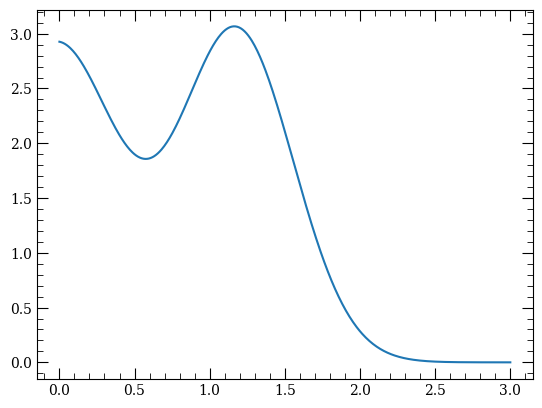

In [79]:
def gv(f):
    a = 2.910
    b = -0.02715
    c = 0.5874
    d = 3.022
    e = 1.179
    g = 0.5337
    return a*np.exp(-((f-b)/c)**2)+d*np.exp(-((f-e)/g)**2)

def gi(f):
    a = 1.187
    b = 6.423
    c = 0.7670
    d = 0.07678
    e = 5.528
    g =0.2381
    return a*(1+d*np.tanh(e*(f-g)))/(1+np.exp(b*(f-c)))
f = np.linspace(0,3,500)
g = gv(f)
print(gv(0))
plt.plot(f,g)

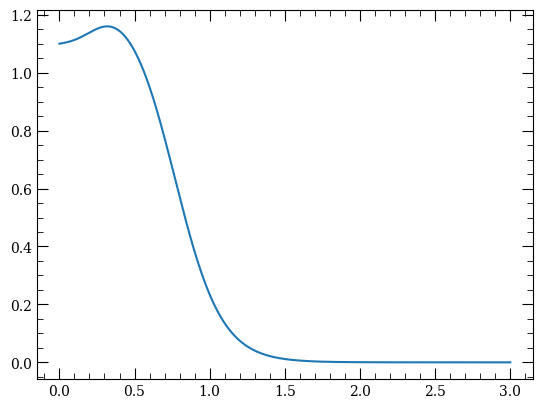

In [80]:
plt.plot(f,gi(f))

<h2>Phase noise</h2>

In [8]:
phase_noise_csv = "638-narrower-scan_28-7-2025.csv"


930.4722569324001
sp: 73.17492600942683, sig: -215.25717813845702


/Users/linipunphuttitarn/Documents/Physics/AQUA/GateErrorSim/phase_noise.py:219: RuntimeWarning: invalid value encountered in log10
  return 10*np.log10(white_noise + bump_noise + nf)


Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
Noise fit of 638nm
td: 0.01989311789835006 ms
noise floor: 1.8330216629684246e-09 = -87.36832402439828 dB
white noise amp, h0: 3.16637412254051 Hz^2/Hz
1: ----- 
	f: 19.98752458355254 kHz, 
	s: 424.7088228763028 Hz, 
	h: 24.884347877545373 Hz^2/Hz,
2: ----- 
	f: 40.09436970502555 kHz, 
	s: 533.7167539882116 Hz, 
	h: 34.83496911264361 Hz^2/Hz,
3: ----- 
	f: 46.00639992903414 kHz, 
	s: 1222.2442915802997 Hz, 
	h: 47.14692222882732 Hz^2/Hz,
4: ----- 
	f: 73.47499686377031 kHz, 
	s: 778.0851150424184 Hz, 
	h: 3.496594703809975 Hz^2/Hz,
5: ----- 
	f: 118.33134763579518 kHz, 
	s: 510.05893503902945 Hz, 
	h: 695.7940578539783 Hz^2/Hz,
6: ----- 
	f: 139.22156627008494 kHz, 
	s: 538.2542330318881 Hz, 
	h: 35.92497117943899 Hz^2/Hz,
7: ----- 
	f: 236.83521869708022 kHz, 
	s: 473.09431477810296 Hz, 
	h: 3837.085925523791 Hz^2/Hz,
8: ----- 
	f: 341.2848951471928 kHz, 
	s: 126157.66121452689 Hz, 
	h: 67.88802

Text(0.5, 0, 'frequency [MHz]')

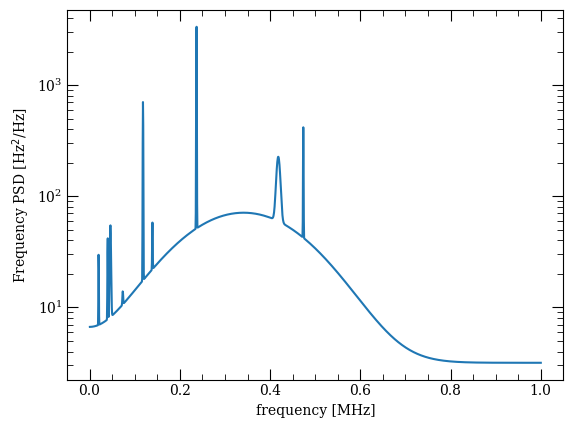

In [91]:
phase_noise_data = procData(phase_noise_csv, True, "638nm", range=1e6, p0=p0dict_638)
label = data_sets[1][1]
vnoise_data = data_sets[1][0]
vnoise_fs = []
vnoise_W = []
for d in vnoise_data:
    if d[0] >=0:
        vnoise_fs.append(d[0]/1e6)
        vnoise_W.append(d[1]*d[0]**2)
fig, ax = plt.subplots()
ax.plot(vnoise_fs, vnoise_W, label=label)
ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_ylabel('Frequency PSD [Hz$^2$/Hz]')
ax.set_xlabel('frequency [MHz]')

error due to phase noise: 7.467062441966722e-05


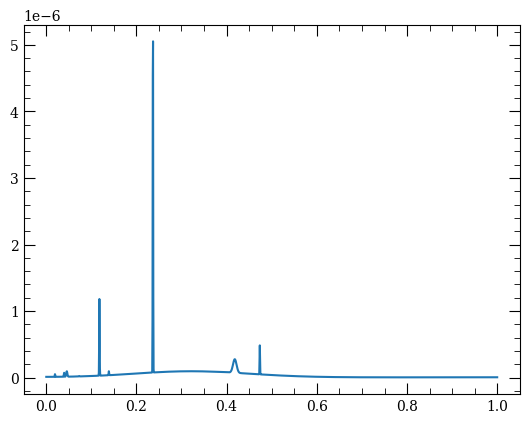

In [69]:
vnoise_fs= np.array(vnoise_fs)
vnoise_W = np.array(vnoise_W)
Omega_Rabi = 1*2*np.pi
contribution = []

# fs  = np.linspace(0,15,500)
# for f in fs:
for i in range(len(f)-1):
    deltaf = f[i+1]-f[i]
    If = gv(f[i]*2*np.pi/Omega_Rabi)/Omega_Rabi**2*4*np.pi*np.pi
    contribution.append(If*phase[i]*deltaf/1e6)
plt.plot(f[:-1], contribution)
print('error due to phase noise:', np.sum(contribution))

<h2>Intensity noise</h2>

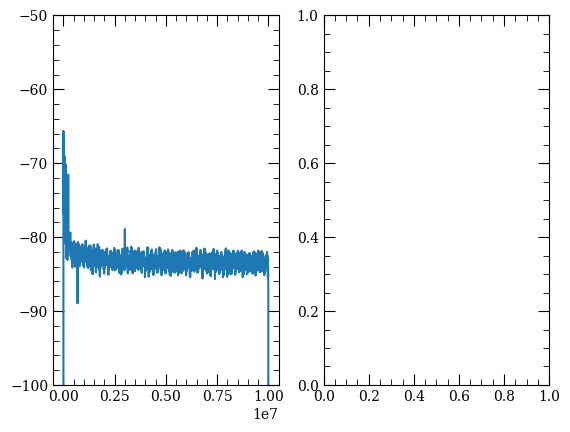

In [421]:
def db_to_w(db):
    # Convert from db to Watt 
    return 10**(db/10)
def w_to_db(db):
    # Convert from watt to db
    return 10*np.log10(db)
RIN_csv_path = '319_Intensity_0.442VDC.csv'
RIN_background_csv_path = 'UV_intensity_background.csv'
intensity_noise_csv = pd.read_csv(RIN_csv_path, header=None)
background_noise_csv = pd.read_csv(RIN_background_csv_path, header=None)
intensity_DC_V = 0.442
fs_intensity = intensity_noise_csv[0]
RIN_db = intensity_noise_csv[1]
fs_background = background_noise_csv[0]
bg_db = background_noise_csv[1]
rbw = fs[1]-fs[0]
carrier_p = (intensity_DC_V**2/50)
bg_w = db_to_w(bg_db)
raw_RIN_w = db_to_w(RIN_db)
RIN_db_c = w_to_db(np.where((raw_RIN_w-bg_w)<0,1e-99,raw_RIN_w-bg_w))
RIN_dbc = (RIN_db-w_to_db(carrier_p)-w_to_db(rbw)) #convert to dBc/Hz= db(W_RIN/W_carrier/Hz) = db(W_RIN)-db(W_carrier)-db(Hz) 
RIN_dbc_c = (RIN_db_c-w_to_db(carrier_p)-w_to_db(rbw))
fig , ax = plt.subplots(ncols=2)
# ax[0].plot(fs_intensity, RIN_dbc)
# ax[0].plot(fs_intensity, RIN_db)
# ax[0].plot(fs_background, bg_db)
ax[0].plot(fs_intensity, RIN_dbc_c)
# ax[0].set_xlim([0.1e6,10e6])
ax[0].set_ylim([-100,-50])
RIN_W = db_to_w(RIN_dbc_c)


In [384]:
fs_intensity[2]-fs_intensity[1]

np.float64(1904.761873)

In [422]:
fs_intensity = np.array(fs_intensity)
RIN_W = np.array(RIN_W)
Omega_Rabi = 1*2*np.pi

Rabis = np.linspace(1,15,100)*2*np.pi
error = []
for Omega_Rabi in Rabis:
    # fs  = np.linspace(0,15,500)
    # for f in fs:
    contribution = []
    for i in range(len(fs_intensity)-1):
        deltaf = fs_intensity[i+1]-fs_intensity[i]
        Ii = gi(fs_intensity[i+1]/1e6*2*np.pi/Omega_Rabi)
        contribution.append(Ii*RIN_W[i+1]*deltaf)
    # plt.plot(fs_intensity[:-1], contribution)
    # print('error due to phase noise:', np.sum(contribution))
    error.append(np.sum(contribution))

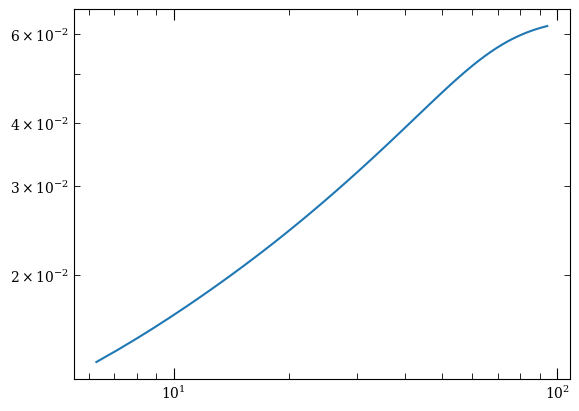

In [423]:
plt.plot(Rabis, error)
plt.yscale('log')
plt.xscale('log')

<h2> linear response </h2>

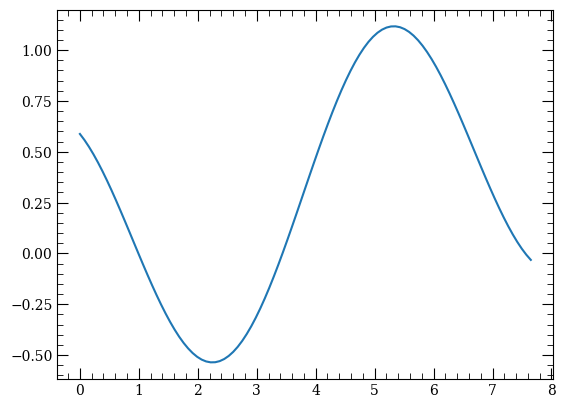

In [60]:
plt.plot(times,phases)

In [74]:
OH01, OH11 = OH(25)
OH01tau, OH11tau = OH(75)
print(OH01[0,0]-OH01tau[0,0])

-2.31533890900255e-17j


In [107]:
OH01t, OH11t = OH(12)
OH01tau, OH11tau = OH(0)
print(np.trace(psi11@OH11t@OH11tau),np.trace(psi11@OH11t)*np.trace(psi11@OH11tau))
# print(np.abs(OH01t/np.pi))

(14.588760419540103-8.66825573616299j) (9.86960440108936+2.2159770912504638e-16j)


In [390]:
A,w, phi, gamma = [2*np.pi*0.1122, 1.0431, -0.7318, 0]#[ 0.71228826,  1.0858492 , -0.60055236,  0]

In [186]:
rabi_rate = Rabi*2*np.pi

In [204]:
Oi01 = np.diag([0, -2*np.pi])
# Oi11 = np.diag([0, -2*np.pi, -2*np.pi])
Oi11 = np.diag([0, -2*np.pi])
psi01 = np.diag([1,0]).astype(dtype=np.complex64)  # single atom state ground and Rydberg
# psi11 = np.diag([1,0,0]).astype(dtype=np.complex64) # two atom state ground-ground, ground-Rydberg, Rydberg-Rydberg 
psi11 = np.diag([1,0]).astype(dtype=np.complex64)

def phases_t(t, A,w,phi,gamma):
    return A*np.cos(w*rabi_rate*t-phi)+gamma*t
def OH(t):
    phases = phases_t(t,A,w,phi,gamma)
    Omega = rabi_rate*np.exp(1j*phases)  
    # print(np.abs(Omega))
    H01 = 0.5*np.array([[0, Omega], [np.conj(Omega), 0]]) 
    # print(np.conj(H01).T)
    H11 = np.sqrt(2)*H01
    # H11 = np.sqrt(2)*0.5*np.array([[0, Omega, 0], [np.conj(Omega), 0, Omega], [0, np.conj(Omega),0]])
    # H11[2,2] = V*np.pi*2/rabi_rate
    OH01 = np.conj(H01).T@Oi01@H01
    OH11 = np.conj(H11).T@Oi11@H11
    return OH01, OH11

    
def linear_response01(t,tau,f):
    # f=0.32*Rabi
    # t = times[t_index]
    # tau = times[tau_index]
    OH01t, OH11t = OH(t)
    OH01tau, OH11tau = OH(tau)
    exOH01_c = np.trace(psi01@OH01t@OH01tau)-np.trace(psi01@OH01t)*np.trace(psi01@OH01tau)
    res01 = np.cos(2*np.pi*f*(t-tau))*exOH01_c
    # print(np.cos(2*np.pi*f*(t-tau)), np.trace(psi01@OH01t@OH01tau), np.trace(psi01@OH01t)*np.trace(psi01@OH01tau))
    return res01

def linear_response11(t,tau,f):
    # t = times[t_index]
    # tau = times[tau_index]
    OH01t, OH11t = OH(t)
    OH01tau, OH11tau = OH(tau)
    exOH11_c = np.trace(psi11@OH11t@OH11tau)-np.trace(psi11@OH11t)*np.trace(psi11@OH11tau)
    res11 = np.cos(2*np.pi*f*(t-tau))*exOH11_c
    # print(np.cos(2*np.pi*f*(t-tau)), np.trace(psi01@OH01t@OH01tau), np.trace(psi01@OH01t)*np.trace(psi01@OH01tau))
    return res11
    
# linear_response01(0.32,0,12)
# linear_response11(0.32,0,12)
fs = np.linspace(0,3*Rabi,50)
response = []
for f in fs:
    val, err = dblquad(linear_response11, 0, 7.65/rabi_rate, lambda tau: 0, lambda tau:7.65/rabi_rate, args=[f])
    response.append(val)


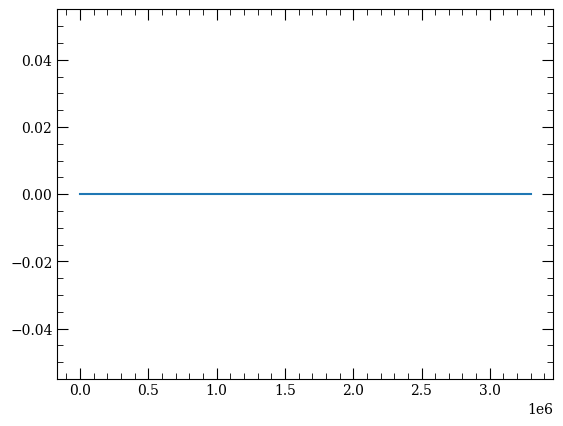

In [206]:
response = np.array(response)

plt.plot(fs,response)

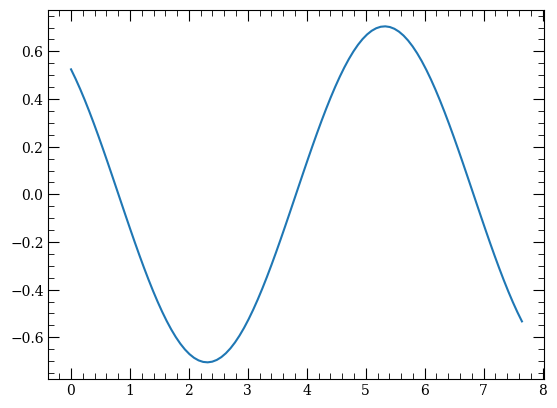

In [404]:
t = np.linspace(0,7.65, 100)
phases = phases_t(t,A,w,phi,gamma)
plt.plot(t,phases)

In [ ]:
psi01 = np.array([1,0], complex)  # single atom state ground and Rydberg
    psi11 = np.array([1,0,0], complex) # two atom state ground-ground, ground-Rydberg, Rydberg-Rydberg 
    if B is None:  #None is infinite blockade
        psi11 = np.array([1,0], complex)  # dont need the 3rd element if blockade is infinite
        
    for i in range(resolution):  #loop over small time increments and apply small unitary rotations at each step
        dt = times[i+1]-times[i]  #time increment difference
        Omega = np.exp(1j*phases(t)  #set up the complex Rabi frequency
        H01 = 0.5*np.array([[0, Omega], [np.conj(Omega), 0]]) #Hamiltonian for one atom 
                if B is None:
            H11 = np.sqrt(2)*H01   # Hamiltonian for two atoms when the blockade is infinite
        else:
            H11 = np.sqrt(2)*0.5*np.array([[0, Omega, 0], [np.conj(Omega), 0, Omega], [0, np.conj(Omega), 0]])   # Hamiltonian for two atoms
            H11[2,2] = B-1j*DecayRate # add in finite blockade and decay for the double exciation term
        H01[1,1] = -1j*DecayRate/2  # add in decay for the single excitation term for the one atom Hamiltonian
        H11[1,1] = -1j*DecayRate/2  # add in decay for the single excitation term for the two atom Hamiltonian
        psi01 = scipy.linalg.expm(-1j*H01*dt)@psi01  #evolve input 1 atom state in time
        psi11 = scipy.linalg.expm(-1j*H11*dt)@psi11  #evolve 2 atom state
    
    # Apply single qubit gates
    phase = psi01[0]/np.abs(psi01[0]) # Calculate the phase shift induced on the ground state for 1 atom
    psi01/=phase  # divide 1 atom state by phase shift
    psi11/=phase**2 #divide 2 atom state by 1 atom phase shift on each atom

In [430]:
np.abs(psi[3])

np.float64(0.9986443005226029)

[0.00000000e+00 0.00000000e+00 0.00000000e+00 6.71540211e+01
 0.00000000e+00 0.00000000e+00 4.76543977e+01 4.76543977e+01
 4.77240549e-06]


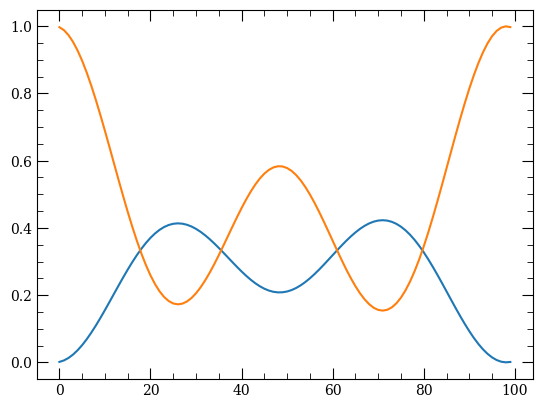

In [429]:
psi = np.zeros((9),complex)
psi[3] = 1
population = []
resolution = 100
dt = 2*np.pi/100
ts = np.linspace(0, 7.65,resolution)
for t in ts:
    H0 = Ht(t)
    dt = ts[1]-ts[0]
    psi = scipy.linalg.expm(-1j*H0*dt)@psi
    population.append(psi)

population = np.array(population)
# plt.plot(abs(population[:,-5,0]**2))
# plt.plot(abs(population[:,-3]**2))
plt.plot(abs(population[:,-2]**2))
plt.plot(abs(population[:,3]**2))
print(np.sum(np.abs(population),axis=0))
psi01 = psi[2]

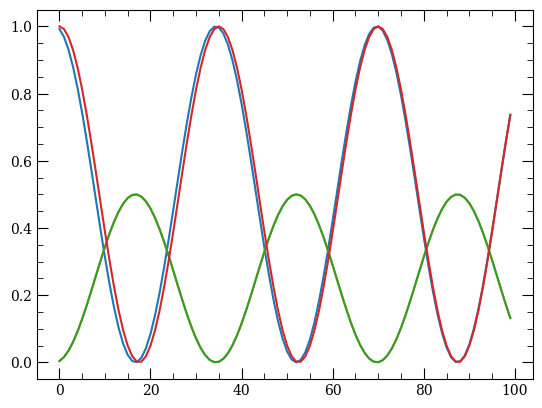

In [342]:
psi = np.zeros((9,1),complex)
psi[3] = 1
population = []
resolution = 100
dt = 2*np.pi/100
O = 1
d = 1
V=1e10
H0 = np.array([[0,0,0,0,0,0,0,0,0],
               [0,0,0,0,O,0,0,0,0],
               [0,0,0,0,0,O,0,0,0],
               [0,0,0,0,0,0,O,O,0],
               [0,d,0,0,d1,0,0,0,0],
               [0,0,d,0,0,d2,0,0,0],
               [0,0,0,d,0,0,d2,0,O],
               [0,0,0,d,0,0,0,d1,O],
               [0,0,0,0,0,0,d,d,V+d1+d2]
              ])
for i in range(resolution):
    # O = 1
    psi = scipy.linalg.expm(-1j*H0*dt)@psi
    population.append(psi)
    
population = np.array(population)
plt.plot(abs(population[:,3,0]**2))
plt.plot(abs(population[:,-2,0]**2))
plt.plot(abs(population[:,-3,0]**2))
t = np.linspace(0, 2*np.pi,100)
plt.plot(np.cos(np.sqrt(2)*t)**2)

In [441]:
d1 =0 
d2 =0 
V= 10000000
oi  = np.array([[0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0],
               [0,0,0,0,-2*np.pi,0,0,0,0],
               [0,0,0,0,0,-2*np.pi,0,0,0],
               [0,0,0,0,0,0,-2*np.pi,0,0],
               [0,0,0,0,0,0,0,-2*np.pi,0],
               [0,0,0,0,0,0,0,0,-2*np.pi]])

def Ht(t):
    phases = phases_t(t,A,w,phi,gamma)
    O = 1*np.exp(-1j*phases)/2
    d = 1*np.exp(1j*phases)/2
    # print(np.abs(Omega))
    H0 = np.array([[0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,O,0,0,0,0],
                   [0,0,0,0,0,O,0,0,0],
                   [0,0,0,0,0,0,O,O,0],
                   [0,d,0,0,d1,0,0,0,0],
                   [0,0,d,0,0,d2,0,0,0],
                   [0,0,0,d,0,0,d2,0,O],
                   [0,0,0,d,0,0,0,d1,O],
                   [0,0,0,0,0,0,d,d,V+d1+d2]
                  ])
    return H0
def OH(t):
    H0 = Ht(t)
    OH = np.conj(H0).T@oi@H0
    return OH

def phases_t(t, A,w,phi,gamma):
    return A*np.cos(w*t-phi)+gamma*t

def linear_response(t,tau,f, pho):
    # f=0.32*Rabi
    # t = times[t_index]
    # tau = times[tau_index]
    OHt = OH(t)
    OHtau = OH(tau)
    exOH_c = np.trace(pho@OHt@OHtau)-np.trace(pho@OHt)*np.trace(pho@OHtau)
    res01 = np.cos(f*(t-tau))*exOH_c
    # print(np.cos(2*np.pi*f*(t-tau)), np.trace(psi01@OH01t@OH01tau), np.trace(psi01@OH01t)*np.trace(psi01@OH01tau))
    return res01

# val, err = dblquad(linear_response, 0, 7.65, lambda tau: 0, lambda tau:7.65, args=[f, pho])
# val/4/np.pi/np.pi

In [439]:
states = [{0:1},
          {1:1},
          {2:1},
          {3:1},
          
          {0:1/np.sqrt(2),3:1/np.sqrt(2)},
          {0:1/np.sqrt(2),3:-1/np.sqrt(2)},
          {1:1/np.sqrt(2),2:1/np.sqrt(2)},
          {1:1/np.sqrt(2),2:-1/np.sqrt(2)},
          {0:1/np.sqrt(2),3:1j/np.sqrt(2)},
          {0:1/np.sqrt(2),3:-1j/np.sqrt(2)},
          
          {0:1/np.sqrt(2),1:1/np.sqrt(2)},
          {0:1/np.sqrt(2),1:-1/np.sqrt(2)},
          {2:1/np.sqrt(2),3:1/np.sqrt(2)},
          {2:1/np.sqrt(2),3:-1/np.sqrt(2)},
          {0:1/np.sqrt(2),1:1j/np.sqrt(2)},
          {0:1/np.sqrt(2),1:-1j/np.sqrt(2)},
          {2:1/np.sqrt(2),3:1j/np.sqrt(2)},
          {2:1/np.sqrt(2),3:-1j/np.sqrt(2)},
          {0:1/2, 1:1/2, 2:1/2, 3:1/2},
          {0:1/2, 1:1j/2, 2:1/2, 3:1j/2}]
error = []
gv_new =[]
fs = np.linspace(0,5,100)
for f in fs:
    for state in states:
        psi = np.zeros((9,1),complex)
        for ind, val in state.items():
            psi[ind] = val
        pho = psi@psi.conj().T
        # print(pho.shape)
        val, err = dblquad(linear_response, 0, 7.65, lambda tau: 0, lambda tau:7.65, args=[f, pho])
        error.append(val)
    gv_new.append(np.mean(error)/4/np.pi/np.pi)

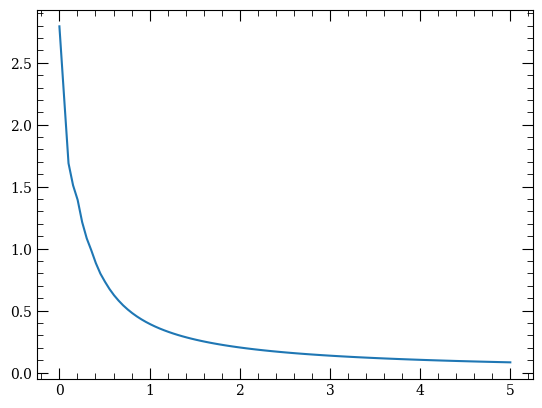

In [440]:
plt.plot(fs, gv_new)

<h2>Universal Response - 1 photon</h2>

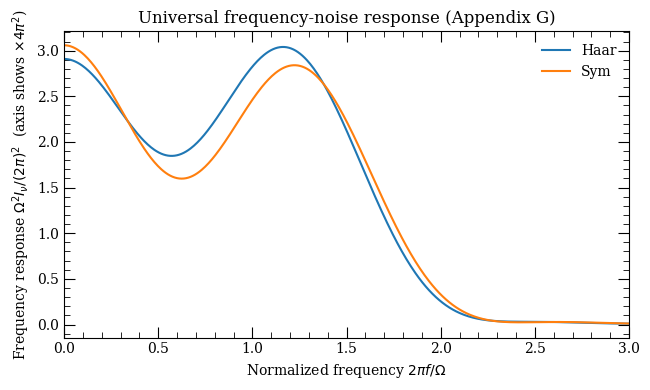

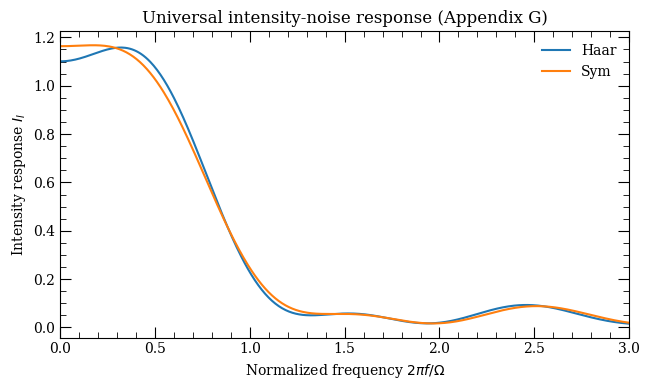

In [129]:
"""
Universal response functions for the ideal time-optimal CZ gate
(PRX Quantum 6, 010331 (2025), Appendix G; Fig. 15).

Computes:
  - Frequency-noise response:  Ω^2 I_ν(f;Ω)  (often plotted as (Ω^2 I_ν)/(2π)^2 with "×4π^2")
  - Intensity-noise response:  I_I(f;Ω)

Averages:
  - "Haar": two-qubit Haar random states (D=4 logical subspace)
  - "Sym" : symmetric-subspace Haar random states (D=3)

Key point: the *state average* is implemented using Eq. (G13),
not Monte Carlo and not the naive "project-then-trace" shortcut.
"""

import numpy as np
import matplotlib.pyplot as plt


# -----------------------------
# 1) Gate parameters (time-optimal CZ example)
# -----------------------------
Omega = 1.0  # set units so Ω=1; universal curves depend only on ω/Ω
A = 2 * np.pi * 0.1122
w = 1.0431 * Omega
phi0 = -0.7318
delta0 = 0.0
T = 2 * np.pi * 1.215 / Omega  # ΩT/(2π)=1.215

# Blockade: "large" is enough to approximate B→∞ for response curves
B = 5e3 * Omega

# Discretization
Nt = 2400
t = np.linspace(0.0, T, Nt)
dt = t[1] - t[0]


def phi(tt: float) -> float:
    return A * np.cos(w * tt - phi0) + delta0 * tt


# -----------------------------
# 2) Basis and ideal Hamiltonian H0(t)
# -----------------------------
# 9D basis: |00>,|01>,|10>,|11>,|0r>,|r0>,|1r>,|r1>,|rr>
dim = 9
idx = {"00": 0, "01": 1, "10": 2, "11": 3, "0r": 4, "r0": 5, "1r": 6, "r1": 7, "rr": 8}


def H0(tt: float) -> np.ndarray:
    """
    Ideal CZ Hamiltonian in the simplified model:
      H0(t) = (Ω/2) Σ_i ( e^{-iφ(t)} |1_i><r_i| + h.c. ) + B |rr><rr|
    expressed in the 9D truncated basis above.
    """
    ph = phi(tt)
    e = np.exp(-1j * ph)
    H = np.zeros((dim, dim), dtype=complex)

    # Qubit 2 couplings:
    # |01> <-> |0r|
    H[idx["01"], idx["0r"]] += (Omega / 2) * e
    H[idx["0r"], idx["01"]] += (Omega / 2) * np.conj(e)
    # |11> <-> |1r|
    H[idx["11"], idx["1r"]] += (Omega / 2) * e
    H[idx["1r"], idx["11"]] += (Omega / 2) * np.conj(e)
    # |r1> <-> |rr|
    H[idx["r1"], idx["rr"]] += (Omega / 2) * e
    H[idx["rr"], idx["r1"]] += (Omega / 2) * np.conj(e)

    # Qubit 1 couplings:
    # |10> <-> |r0|
    H[idx["10"], idx["r0"]] += (Omega / 2) * e
    H[idx["r0"], idx["10"]] += (Omega / 2) * np.conj(e)
    # |11> <-> |r1|
    H[idx["11"], idx["r1"]] += (Omega / 2) * e
    H[idx["r1"], idx["11"]] += (Omega / 2) * np.conj(e)
    # |1r> <-> |rr|
    H[idx["1r"], idx["rr"]] += (Omega / 2) * e
    H[idx["rr"], idx["1r"]] += (Omega / 2) * np.conj(e)

    # Blockade shift
    H[idx["rr"], idx["rr"]] += B
    return H


# -----------------------------
# 3) Noise operators (instantaneous)
# -----------------------------
def O_nu() -> np.ndarray:
    """
    Frequency noise operator (detuning noise):
      O_ν = -2π Σ_i |r_i><r_i|
    In this truncated basis: singly excited r-states contribute -2π,
    and |rr> contributes -4π.
    """
    O = np.zeros((dim, dim), dtype=complex)
    for k in ["0r", "r0", "1r", "r1"]:
        O[idx[k], idx[k]] += -2 * np.pi
    O[idx["rr"], idx["rr"]] += -4 * np.pi
    return O


def O_I_inst(tt: float) -> np.ndarray:
    """
    Intensity noise operator (amplitude noise):
      O_I(t) = (Ω/4) Σ_i ( e^{-iφ(t)} |1_i><r_i| + h.c. )
    Same graph as H0 but Ω/4 instead of Ω/2.
    """
    ph = phi(tt)
    e = np.exp(-1j * ph)
    pref = Omega / 4
    O = np.zeros((dim, dim), dtype=complex)

    # Qubit 2 edges
    O[idx["01"], idx["0r"]] += pref * e
    O[idx["0r"], idx["01"]] += pref * np.conj(e)
    O[idx["11"], idx["1r"]] += pref * e
    O[idx["1r"], idx["11"]] += pref * np.conj(e)
    O[idx["r1"], idx["rr"]] += pref * e
    O[idx["rr"], idx["r1"]] += pref * np.conj(e)

    # Qubit 1 edges
    O[idx["10"], idx["r0"]] += pref * e
    O[idx["r0"], idx["10"]] += pref * np.conj(e)
    O[idx["11"], idx["r1"]] += pref * e
    O[idx["r1"], idx["11"]] += pref * np.conj(e)
    O[idx["1r"], idx["rr"]] += pref * e
    O[idx["rr"], idx["1r"]] += pref * np.conj(e)

    return O


# -----------------------------
# 4) Stable propagation: U_{k+1} = exp(-i H(t_mid) dt) U_k
# -----------------------------
def step_unitary(H: np.ndarray, dt_: float) -> np.ndarray:
    evals, evecs = np.linalg.eigh(H)  # H is Hermitian
    return (evecs * np.exp(-1j * evals * dt_)) @ evecs.conj().T


def propagate_U() -> np.ndarray:
    U = np.eye(dim, dtype=complex)
    Us = np.empty((Nt, dim, dim), dtype=complex)
    Us[0] = U
    for k in range(Nt - 1):
        tm = 0.5 * (t[k] + t[k + 1])
        U = step_unitary(H0(tm), dt) @ U
        Us[k + 1] = U
    return Us


# -----------------------------
# 5) Build Heisenberg sequences O_H(t) = U† O_inst(t) U
# -----------------------------
def build_Oseq(is_intensity: bool) -> np.ndarray:
    Us = propagate_U()
    Udag = np.conjugate(np.swapaxes(Us, 1, 2))

    Onu = O_nu()
    Oseq = np.empty((Nt, dim, dim), dtype=complex)
    for k in range(Nt):
        Oinst = O_I_inst(t[k]) if is_intensity else Onu
        Oseq[k] = Udag[k] @ Oinst @ Us[k]
    return Oseq


# -----------------------------
# 6) Appendix G average (Eq. G13) implemented via correlations
# -----------------------------
def response_G13(Oseq: np.ndarray, S: np.ndarray, omegas: np.ndarray) -> np.ndarray:
    """
    Computes the universal response I(ω) for ω in omegas using Eq. (G13)
    with an isometry S (dim x D) defining the Haar ensemble subspace.
      P = S S†  (projector), D = Tr(P)

    Discrete form:
      I(ω) ≈ Σ_{j,k} cos(ω (t_j - t_k)) * K(t_j, t_k) * dt^2
    where K is the Eq.(G13) averaged connected correlator.
    """
    Nt_local = Oseq.shape[0]
    D = S.shape[1]
    Sdag = S.conj().T

    # Sequences needed for correlations
    # X(t)=S† O(t)  (D x dim),  Y(t)=O(t) S (dim x D)
    X = np.einsum("ad,tdk->tak", Sdag, Oseq)   # (Nt, D, dim)
    Y = np.einsum("tdk,kb->tdb", Oseq, S)      # (Nt, dim, D)

    # M(t)=S† O(t) S (D x D)
    M = np.einsum("ad,tdk,kb->tab", Sdag, Oseq, S)  # (Nt, D, D)

    # c(t)=Tr[O(t)P]=Tr[M(t)]
    c = np.trace(M, axis1=1, axis2=2)  # (Nt,)

    # Build lag correlations over k = -(Nt-1)...(Nt-1):
    # A_k = Σ_l Tr[ S†O(l+k) O(l) S ]  = Σ_l Tr[ X(l+k) Y(l) ]
    A_corr = np.zeros(2 * Nt_local - 1, dtype=complex)
    for a in range(D):
        for j in range(dim):
            A_corr += np.correlate(X[:, a, j], np.conj(Y[:, j, a]), mode="full")

    # B_k = Σ_l Tr[ M(l+k) M(l) ]
    B_corr = np.zeros(2 * Nt_local - 1, dtype=complex)
    for a in range(D):
        for b in range(D):
            B_corr += np.correlate(M[:, a, b], np.conj(M[:, b, a]), mode="full")

    # C_k = Σ_l c(l+k) c(l)
    C_corr = np.correlate(c, np.conj(c), mode="full")

    # Eq. (G13) kernel summed over the second time index:
    # Ksum(k) = (1/D) A_k - 1/(D(D+1)) (B_k + C_k)
    Ksum = (1.0 / D) * A_corr - (1.0 / (D * (D + 1.0))) * (B_corr + C_corr)

    # Discrete double integral factor
    K = np.real(Ksum) * (dt * dt)

    lags = np.arange(-(Nt_local - 1), Nt_local)
    tau = lags * dt

    # I(ω) = Σ_k K(k) cos(ω tau_k)
    return np.array([np.sum(K * np.cos(w_ * tau)) for w_ in omegas])


# -----------------------------
# 7) Convenience wrappers for Haar and Sym subspaces
# -----------------------------
def isometry_haar_full() -> np.ndarray:
    """Isometry S (dim x 4) embedding logical {|00>,|01>,|10>,|11>} into full 9D."""
    S = np.zeros((dim, 4), dtype=complex)
    for i in range(4):
        S[i, i] = 1.0
    return S


def isometry_symmetric() -> np.ndarray:
    """Isometry S (dim x 3) for the symmetric logical subspace."""
    S = np.zeros((dim, 3), dtype=complex)
    S[idx["00"], 0] = 1.0
    S[idx["01"], 1] = 1 / np.sqrt(2)
    S[idx["10"], 1] = 1 / np.sqrt(2)
    S[idx["11"], 2] = 1.0
    return S


# -----------------------------
# 8) Main: compute universal curves and plot
# -----------------------------
if __name__ == "__main__":
    # Frequency axis: x = ω/Ω = 2π f/Ω (as in Fig. 15)
    x = np.linspace(0.0, 3.0, 501)
    omegas = x * Omega

    # Build Heisenberg sequences
    Oseq_nu = build_Oseq(is_intensity=False)
    Oseq_I = build_Oseq(is_intensity=True)

    # Isometries
    S_haar = isometry_haar_full()   # D=4
    S_sym = isometry_symmetric()    # D=3

    # Responses (Appendix G Eq. G13)
    I_nu_haar = response_G13(Oseq_nu, S_haar, omegas)
    I_nu_sym = response_G13(Oseq_nu, S_sym, omegas)
    I_I_haar = response_G13(Oseq_I, S_haar, omegas)
    I_I_sym = response_G13(Oseq_I, S_sym, omegas)

    # Fig. 15(a) convention often shown as Ω^2 Iν/(2π)^2 with "×4π^2"
    nu_plot_haar = (Omega**2) * I_nu_haar / ((2 * np.pi) ** 2)
    nu_plot_sym = (Omega**2) * I_nu_sym / ((2 * np.pi) ** 2)

    # Plot (a): frequency response
    plt.figure(figsize=(6.6, 4.0))
    plt.plot(x, nu_plot_haar, label="Haar")
    plt.plot(x, nu_plot_sym, label="Sym")
    plt.xlim(0, 3.0)
    plt.xlabel(r"Normalized frequency $2\pi f/\Omega$")
    plt.ylabel(r"Frequency response $\Omega^2 I_\nu/(2\pi)^2$  (axis shows $\times 4\pi^2$)")
    plt.title("Universal frequency-noise response (Appendix G)")
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()

    # Plot (b): intensity response
    plt.figure(figsize=(6.6, 4.0))
    plt.plot(x, I_I_haar, label="Haar")
    plt.plot(x, I_I_sym, label="Sym")
    plt.xlim(0, 3.0)
    plt.xlabel(r"Normalized frequency $2\pi f/\Omega$")
    plt.ylabel(r"Intensity response $I_I$")
    plt.title("Universal intensity-noise response (Appendix G)")
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()

<h2>Universal Response - 2photons</h2>

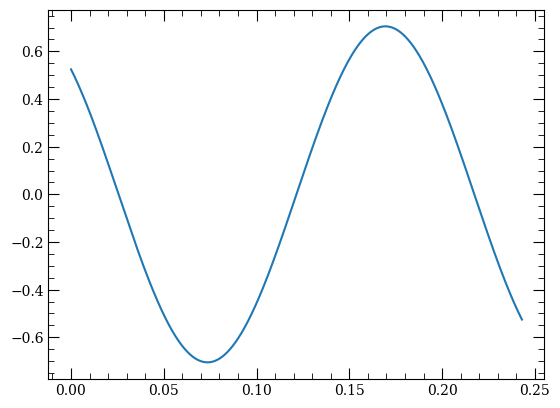

In [434]:
plt.plot(t,phi_eff(t))

In [435]:
n

60

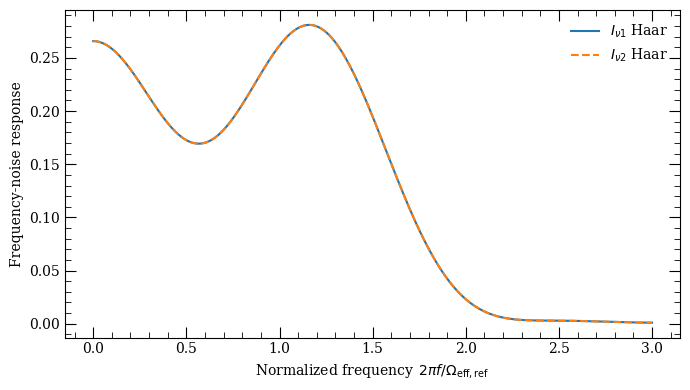

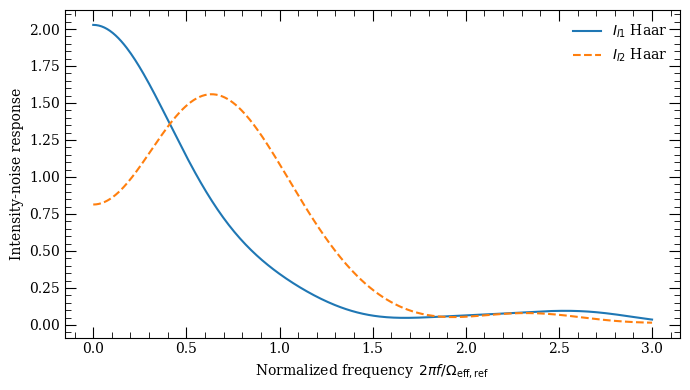

In [437]:
"""
Universal response functions for a TWO-PHOTON Rydberg CZ gate
(PRX Quantum 6, 010331 (2025) Appendix K + Appendix G).

Model:
- Use Appendix K effective 3-level Hamiltonian (|0>,|1>,|r|) per atom,
  after adiabatically eliminating |e| in the limit Δ >> Ω1,Ω2 (Eq. K7).
- Two atoms => 3x3 = 9-dimensional Hilbert space (same size as the
  single-photon toy model), basis: |00>,|01>,|10>,|11>,|0r>,|r0>,|1r>,|r1>,|rr>.

Noise operators (effective 3-level):
- Intensity noise: O_I1(t), O_I2(t)  (Eqs. K8, K9)
- Frequency noise: O_ν1(t), O_ν2(t)  (Eqs. K10, K11)
Each response function is computed with the Haar-average formula Eq. (G13)
(using the correlation implementation from earlier).

You must supply:
- Ω1(t), Ω2(t) pulse envelopes (can be constant)
- Δ (intermediate detuning)
- κ̃0,1 κ̃r,1 κ̃0,2 κ̃r,2 (relative polarizabilities as defined in App. K)
- Detuning modulations δ1(t), δ2(t) if you want them
- Optional: a phase modulation φ_eff(t) on the effective |1><->|r| coupling
  (if you implement FM via optical phases; see comment near coupling term).

References:
- Effective Hamiltonian: Eq. (K7) [oai_citation:4‡PRXQuantum.6.010331.pdf](sediment://file_00000000ff6871f898efa8a5b8425e17)
- Effective noise ops:   Eqs. (K8)-(K11) [oai_citation:5‡PRXQuantum.6.010331.pdf](sediment://file_00000000ff6871f898efa8a5b8425e17)
- Total infidelity sum:  Eq. (K6) [oai_citation:6‡PRXQuantum.6.010331.pdf](sediment://file_00000000ff6871f898efa8a5b8425e17)
"""

import numpy as np
import matplotlib.pyplot as plt


# -----------------------------
# 1) Time grid
# -----------------------------



# -----------------------------
# 2) User-supplied control waveforms
# -----------------------------
# Example: constant envelopes

Omega_eff = 3.3*2*np.pi #MHz*2pi
inter_detuning = 5000*2*np.pi #MHz*2pi
# Blockade
Blockade = 50*2*np.pi  # large -> blockade-dominated limit

Omega1_0 = np.sqrt(2*Omega_eff*inter_detuning)
Omega2_0 = np.sqrt(2*Omega_eff*inter_detuning)

# normalizing_factor = np.sqrt(Omega_eff*2*inter_detuning)
# print(normalizing_factor/2/np.pi)
# Intermediate detuning (Δ in Appendix K; called "Δ" or similar)
Delta = inter_detuning#/normalizing_factor  # must satisfy Delta >> Omega1,Omega2 in the effective model



T = 2 * np.pi * 1.215 /Omega_eff      # set gate time (units arbitrary); adjust as needed
Nt = 200
t = np.linspace(0.0, T, Nt)
dt = t[1] - t[0]

B = Blockade

def Omega1(tt: float) -> float:
    return Omega1_0

def Omega2(tt: float) -> float:
    return Omega2_0


# Optional additional detuning modulations (δ1, δ2) in Eq. (K7)
def delta1(tt: float) -> float:
    return (ktilder_1*Omega1_0**2+ktilder_2*Omega2_0**2)

# def delta2(tt: float) -> float:
#     return 0.0
def delta2(t):
    return 0
    
# Optional: effective phase modulation on the two-photon coupling
# If the optical phases of the two arms are φ1(t), φ2(t),
# then the effective two-photon coupling can carry phase exp(-i(φ1+φ2)).
def phi_eff(tt: float) -> float:
    tt_eff = tt/2/Delta*Omega1_0*Omega2_0
    return A * np.cos(w * tt_eff - phi0) + delta0 * tt_eff



# -----------------------------
# 3) Polarizability parameters (Appendix K definitions)
# -----------------------------
# Appendix K suggests defining:
#   κ̃0,j = κ0,j - κ1,j   and   κ̃r,j = κr,j - κ1,j  (relative to |1>)
# (see App. K discussion around Eq. K7) [oai_citation:7‡PRXQuantum.6.010331.pdf](sediment://file_00000000ff6871f898efa8a5b8425e17)


atom = Cesium()
v_photon1 = atom.getTransitionFrequency(n1=6, l1=0, j1=1/2, n2=7, l2=1, j2=1/2, s=0.5)
v_photon1 += inter_detuning*1e6/2/np.pi
v_photon2 = atom.getTransitionFrequency(n1=6, l1=1, j1=1/2, n2=n, l2=0, j2=1/2, s=0.5)
v_photon2 -= inter_detuning*1e6/2/np.pi


alpha_g_gen = DynamicPolarizability(atom, n=6, l=1, j=1/2, s=0.5)
alpha_g_gen.defineBasis(6, 9)
alpha_r_gen = DynamicPolarizability(atom, n=n, l=0, j=1/2, s=0.5)
alpha_r_gen.defineBasis(6, n+20)

alpha_r_1 = alpha_r_gen.getPolarizability(c/(v_photon1), units='SI', accountForStateLifetime=False, mj=None)[0]
d1 = atom.getDipoleMatrixElement(n1=6, l1=0, j1=1/2, mj1=-1/2, n2=7, l2=1, j2=1/2, mj2=1/2,q=1, s=0.5)*bohr_r/hbar*e

ktilde0_1 = -(1/4/(Delta+w_qubit/1e6)-1/4/Delta)
ktilder_1 = -(alpha_r_1*2*np.pi*1e6)/4/d1**2+1/4/Delta



d2 = atom.getDipoleMatrixElement(n1=7, l1=1, j1=1/2, mj1=1/2, n2=n, l2=0, j2=1/2, mj2=-1/2,q=-1, s=0.5)*bohr_r/hbar*e
alpha_1_2 = alpha_g_gen.getPolarizability(c/(v_photon2), units='SI', accountForStateLifetime=False, mj=None)[0]

ktilde0_2 = 0.0
ktilder_2 = -1/4/Delta+(alpha_1_2*2*np.pi*1e6)/4/d2**2




# -----------------------------
# 4) Basis (same 9D as single-photon toy model)
# -----------------------------
dim = 9
idx = {"00":0, "01":1, "10":2, "11":3, "0r":4, "r0":5, "1r":6, "r1":7, "rr":8}


# -----------------------------
# 5) Effective Hamiltonian H_eff(t) (Eq. K7)
# -----------------------------
def H_eff(tt: float) -> np.ndarray:
    """
    Implements Eq. (K7) in the 9D basis.

    Eq. (K7) structure:
      H_eff =
        (Ω1 Ω2)/(4Δ) Σ_i ( |1_i><r_i| + h.c. )
        + (Ω1^2)/(Δ) * light shifts on |0> and |r| (relative to |1|) for arm 1
        + (Ω2^2)/(Δ) * light shifts on |0> and |r| (relative to |1|) for arm 2
        - { δ1+δ2 + (Ω1^2-Ω2^2)/(4Δ) } Σ_i |r_i><r_i|
        + B |rr><rr|
    with coefficients as written in Eq. (K7). [oai_citation:8‡PRXQuantum.6.010331.pdf](sediment://file_00000000ff6871f898efa8a5b8425e17)

    NOTE: The parsed PDF formatting can drop some parentheses; this implementation
    follows the displayed Eq. (K7) and the consistency with the effective noise
    operators (K8,K9).
    """
    Om1 = Omega1(tt)
    Om2 = Omega2(tt)
    de1 = delta1(tt)
    de2 = delta2(tt)

    # Effective two-photon coupling strength in Eq. (K7): Ω1Ω2/(4Δ)
    Oeff = (Om1 * Om2) / (4.0 * Delta)

    # Optional phase on effective coupling
    phase = np.exp(-1j * phi_eff(tt))

    # Self-light-shift term in Eq. (K7): (Ω1^2 - Ω2^2)/(4Δ)
    self_ls = (Om1*Om1 - Om2*Om2) / (4.0 * Delta)

    # Build Hamiltonian
    H = np.zeros((dim, dim), dtype=complex)

    # --- Effective |1><->|r| couplings (apply to each atom) ---
    # Atom 2: |01><->|0r| and |11><->|1r| and |r1><->|rr|
    H[idx["01"], idx["0r"]] += Oeff * phase
    H[idx["0r"], idx["01"]] += Oeff * np.conj(phase)

    H[idx["11"], idx["1r"]] += Oeff * phase
    H[idx["1r"], idx["11"]] += Oeff * np.conj(phase)

    H[idx["r1"], idx["rr"]] += Oeff * phase
    H[idx["rr"], idx["r1"]] += Oeff * np.conj(phase)

    # Atom 1: |10><->|r0| and |11><->|r1| and |1r><->|rr|
    H[idx["10"], idx["r0"]] += Oeff * phase
    H[idx["r0"], idx["10"]] += Oeff * np.conj(phase)

    H[idx["11"], idx["r1"]] += Oeff * phase
    H[idx["r1"], idx["11"]] += Oeff * np.conj(phase)

    H[idx["1r"], idx["rr"]] += Oeff * phase
    H[idx["rr"], idx["1r"]] += Oeff * np.conj(phase)

    # --- Light shifts from arm 1 and arm 2 on |0> and |r| relative to |1| ---
    # From Eq. (K7), these scale ~ Ωj^2/Δ with coefficients κ̃.
    ls1 = (Om1*Om1)
    ls2 = (Om2*Om2)

    # Apply |0> shifts: both atoms, so |00>,|01>,|10> get one/two contributions.
    # In this truncated basis we add shifts depending on how many qubits are in |0>.
    # (This is the natural embedding of Σ_i |0_i><0_i|.)
    # States containing a |0> on atom 1: |00>,|01>,|0r>
    # States containing a |0> on atom 2: |00>,|10>,|r0>
    for state in ["00", "01", "0r"]:
        H[idx[state], idx[state]] += (ktilde0_1*ls1 + ktilde0_2*ls2)
    for state in ["00", "10", "r0"]:
        H[idx[state], idx[state]] += (ktilde0_1*ls1 + ktilde0_2*ls2)

    # Apply |r> shifts: Σ_i |r_i><r_i| (singly excited r) and |rr| gets 2x
    r_shift = (ktilder_1*ls1 + ktilder_2*ls2)
    for state in ["0r","r0","1r","r1"]:
        H[idx[state], idx[state]] += r_shift
    H[idx["rr"], idx["rr"]] += 2.0 * r_shift

    # --- Detuning-like term on |r> manifold from Eq. (K7) ---
    det_r = (de1 + de2 + self_ls)
    for state in ["0r","r0","1r","r1"]:
        H[idx[state], idx[state]] += -det_r
    H[idx["rr"], idx["rr"]] += -2.0 * det_r

    # Blockade
    H[idx["rr"], idx["rr"]] += B
    return H


# -----------------------------
# 6) Effective noise operators (Eqs. K8-K11)
# -----------------------------
def O_I1(tt: float) -> np.ndarray:
    """
    Intensity-noise operator for arm 1 (Eq. K8). [oai_citation:9‡PRXQuantum.6.010331.pdf](sediment://file_00000000ff6871f898efa8a5b8425e17)
    """
    Om1 = Omega1(tt)
    Om2 = Omega2(tt)

    O = np.zeros((dim, dim), dtype=complex)

    # First term: (Ω1Ω2)/(8Δ) Σ_i (|1_i><r_i| + h.c.)
    Oeff_I = (Om1 * Om2) / (8.0 * Delta)
    phase = np.exp(-1j * phi_eff(tt))

    # same couplings as H_eff, scaled
    for (a,b) in [("01","0r"), ("11","1r"), ("r1","rr"), ("10","r0"), ("11","r1"), ("1r","rr")]:
        O[idx[a], idx[b]] += Oeff_I * phase
        O[idx[b], idx[a]] += Oeff_I * np.conj(phase)

    # + κ̃0,1 * Ω1^2 * Σ_i |0_i><0_i|   (up to the same Ω^2/Δ scaling in Eq. K8)
    # Eq. (K8) shows this as proportional to κ̃0,1 Ω1(t)^2 (formatting is compressed in the PDF parse).
    ls1 = (Om1*Om1)
    for state in ["00", "01", "0r"]:
        O[idx[state], idx[state]] += ktilde0_1 * ls1
    for state in ["00", "10", "r0"]:
        O[idx[state], idx[state]] += ktilde0_1 * ls1

    # + (κ̃r,1 - 1/(4Δ)) * Ω1^2 * Σ_i |r_i><r_i|   (Eq. K8) [oai_citation:10‡PRXQuantum.6.010331.pdf](sediment://file_00000000ff6871f898efa8a5b8425e17)
    coeff_r = (ktilder_1 - 1.0/(4.0*Delta)) * ls1
    for state in ["0r","r0","1r","r1"]:
        O[idx[state], idx[state]] += coeff_r
    O[idx["rr"], idx["rr"]] += 2.0 * coeff_r
    return O


def O_I2(tt: float) -> np.ndarray:
    """
    Intensity-noise operator for arm 2 (Eq. K9). [oai_citation:11‡PRXQuantum.6.010331.pdf](sediment://file_00000000ff6871f898efa8a5b8425e17)
    """
    Om1 = Omega1(tt)
    Om2 = Omega2(tt)

    O = np.zeros((dim, dim), dtype=complex)

    # First term: (Ω1Ω2)/(8Δ) Σ_i (|1_i><r_i| + h.c.)
    Oeff_I = (Om1 * Om2) / (8.0 * Delta)
    phase = np.exp(-1j * phi_eff(tt))

    for (a,b) in [("01","0r"), ("11","1r"), ("r1","rr"), ("10","r0"), ("11","r1"), ("1r","rr")]:
        O[idx[a], idx[b]] += Oeff_I * phase
        O[idx[b], idx[a]] += Oeff_I * np.conj(phase)

    # + κ̃0,2 * Ω2^2 * Σ_i |0_i><0_i|
    ls2 = (Om2*Om2) 
    for state in ["00", "01", "0r"]:
        O[idx[state], idx[state]] += ktilde0_2 * ls2
    for state in ["00", "10", "r0"]:
        O[idx[state], idx[state]] += ktilde0_2 * ls2

    # + (κ̃r,2 + 1/(4Δ)) * Ω2^2 * Σ_i |r_i><r_i|  (Eq. K9) [oai_citation:12‡PRXQuantum.6.010331.pdf](sediment://file_00000000ff6871f898efa8a5b8425e17)
    coeff_r = (ktilder_2 + 1.0/(4.0*Delta)) * ls2
    for state in ["0r","r0","1r","r1"]:
        O[idx[state], idx[state]] += coeff_r
    O[idx["rr"], idx["rr"]] += 2.0 * coeff_r
    return O


def O_nu1(tt: float) -> np.ndarray:
    """
    Frequency-noise operator for laser 1 (Eq. K10). [oai_citation:13‡PRXQuantum.6.010331.pdf](sediment://file_00000000ff6871f898efa8a5b8425e17)
    In the effective 3-level reduction it becomes proportional to Σ_i |r_i><r_i|.
    """
    O = np.zeros((dim, dim), dtype=complex)
    for state in ["0r","r0","1r","r1"]:
        O[idx[state], idx[state]] += -2*np.pi
    O[idx["rr"], idx["rr"]] += -4*np.pi
    return O


def O_nu2(tt: float) -> np.ndarray:
    """
    Frequency-noise operator for laser 2 (Eq. K11). [oai_citation:14‡PRXQuantum.6.010331.pdf](sediment://file_00000000ff6871f898efa8a5b8425e17)
    Same effective form as O_nu1 in this reduction.
    """
    return O_nu1(tt)


# -----------------------------
# 7) Propagation + Eq. (G13) Haar average (same engine as before)
# -----------------------------
def step_unitary(H, dt_):
    evals, evecs = np.linalg.eigh(H)
    return (evecs * np.exp(-1j*evals*dt_)) @ evecs.conj().T

def propagate_U():
    U = np.eye(dim, dtype=complex)
    Us = np.empty((Nt, dim, dim), dtype=complex)
    Us[0] = U
    for k in range(Nt-1):
        tm = 0.5*(t[k]+t[k+1])
        U = step_unitary(H_eff(tm), dt) @ U
        Us[k+1] = U
    return Us

def build_Oseq(Oinst_func):
    Us = propagate_U()
    Udag = np.conjugate(np.swapaxes(Us, 1, 2))
    Oseq = np.empty((Nt, dim, dim), dtype=complex)
    for k in range(Nt):
        Oinst = Oinst_func(t[k])
        Oseq[k] = Udag[k] @ Oinst @ Us[k]
    return Oseq

def response_G13(Oseq, S, omegas):
    """
    Eq. (G13) Haar-average implemented via lag correlations (fast O(Nt log Nt)-ish).
    """
    Nt_local = Oseq.shape[0]
    D = S.shape[1]
    Sdag = S.conj().T

    X = np.einsum("ad,tdk->tak", Sdag, Oseq)        # (Nt, D, dim)
    Y = np.einsum("tdk,kb->tdb", Oseq, S)           # (Nt, dim, D)
    M = np.einsum("ad,tdk,kb->tab", Sdag, Oseq, S)  # (Nt, D, D)
    c = np.trace(M, axis1=1, axis2=2)

    A_corr = np.zeros(2*Nt_local-1, dtype=complex)
    for a in range(D):
        for j in range(dim):
            A_corr += np.correlate(X[:, a, j], np.conj(Y[:, j, a]), mode="full")

    B_corr = np.zeros(2*Nt_local-1, dtype=complex)
    for a in range(D):
        for b in range(D):
            B_corr += np.correlate(M[:, a, b], np.conj(M[:, b, a]), mode="full")

    C_corr = np.correlate(c, np.conj(c), mode="full")

    Ksum = (1.0/D)*A_corr - (1.0/(D*(D+1.0)))*(B_corr + C_corr)
    K = np.real(Ksum) * (dt*dt)

    lags = np.arange(-(Nt_local-1), Nt_local)
    tau = lags * dt
    return np.array([np.sum(K * np.cos(w_*tau)) for w_ in omegas])


# -----------------------------
# 8) Haar and Sym isometries (same as before)
# -----------------------------
def isometry_haar():
    S = np.zeros((dim,4), dtype=complex)
    for i in range(4):
        S[i,i] = 1.0
    return S

def isometry_sym():
    S = np.zeros((dim,3), dtype=complex)
    S[idx["00"],0] = 1.0
    S[idx["01"],1] = 1/np.sqrt(2)
    S[idx["10"],1] = 1/np.sqrt(2)
    S[idx["11"],2] = 1.0
    return S


# -----------------------------
# 9) Main: compute the four universal response functions
# -----------------------------
if __name__ == "__main__":
    # Normalized frequency axis: x = ω / Ω_ref.
    # For two-photon gates, pick a natural reference frequency; commonly the
    # peak effective two-photon Rabi Ω_eff,pk = (Ω1Ω2)/(2Δ) or similar.
    # In Eq. (K7) the coupling is Ω1Ω2/(4Δ), so we’ll use:
    Omega_eff_ref = (Omega1_0 * Omega2_0) / (2.0 * Delta)
    x = np.linspace(0.0, 3.0, 401)
    omegas = x*Omega_eff_ref

    S_haar = isometry_haar()
    S_sym  = isometry_sym()

    # Build Heisenberg operator sequences
    Oseq_I1 = build_Oseq(O_I1)
    Oseq_I2 = build_Oseq(O_I2)
    Oseq_nu1 = build_Oseq(O_nu1)
    Oseq_nu2 = build_Oseq(O_nu2)

    # Responses (Haar + Sym) for each noise operator
    II1_haar = response_G13(Oseq_I1, S_haar, omegas)
    II1_sym  = response_G13(Oseq_I1, S_sym,  omegas)

    II2_haar = response_G13(Oseq_I2, S_haar, omegas)
    II2_sym  = response_G13(Oseq_I2, S_sym,  omegas)

    Inu1_haar = response_G13(Oseq_nu1, S_haar, omegas)
    Inu1_sym  = response_G13(Oseq_nu1, S_sym,  omegas)

    Inu2_haar = response_G13(Oseq_nu2, S_haar, omegas)
    Inu2_sym  = response_G13(Oseq_nu2, S_sym,  omegas)

    # Plot examples
    plt.figure(figsize=(7,4))
    plt.plot(x, Inu1_haar, label=r"$I_{\nu1}$ Haar")
    # plt.plot(x, Inu1_sym,  label=r"$I_{\nu1}$ Sym")
    plt.plot(x, Inu2_haar, "--", label=r"$I_{\nu2}$ Haar")
    # plt.plot(x, Inu2_sym,  "--", label=r"$I_{\nu2}$ Sym")
    plt.xlabel(r"Normalized frequency $\,2 \pi f/\Omega_{\mathrm{eff,ref}}$")
    plt.ylabel("Frequency-noise response")
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(x, II1_haar, label=r"$I_{I1}$ Haar")
    # plt.plot(x, II1_sym,  label=r"$I_{I1}$ Sym")
    plt.plot(x, II2_haar, "--", label=r"$I_{I2}$ Haar")
    # plt.plot(x, II2_sym,  "--", label=r"$I_{I2}$ Sym")
    plt.xlabel(r"Normalized frequency $\,2 \pi f/\Omega_{\mathrm{eff,ref}}$")
    plt.ylabel("Intensity-noise response")
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()

    # Leading-order infidelity is the PSD-weighted sum (Eq. K6). [oai_citation:15‡PRXQuantum.6.010331.pdf](sediment://file_00000000ff6871f898efa8a5b8425e17)
    # 1-F = ∫ df [ Sν1(f)Iν1(f)+Sν2(f)Iν2(f)+SI1(f)II1(f)+SI2(f)II2(f) ].

In [441]:
###Scattering off intermediate state
tau_7p = atom.getStateLifetime(n=7,l=1,j=1/2,temperature=300, includeLevelsUpTo=n+20,s=0.5)*1e6
0.95/Omega_Rabi/tau_7p*Omega1_0**2/(inter_detuning+w_qubit)**2 + 0.95/Omega_Rabi/tau_7p*(Omega1_0**2+Omega2_0**2)/(inter_detuning)**2+0.12/Omega_Rabi/tau_7p*(Omega1_0**2-Omega2_0**2)/(inter_detuning)**2

np.float64(0.00017248056862980758)

In [375]:
logical = ["00","01","10","11"]
rydberg = ["0r","r0","1r","r1","rr"]
def basis_state(label):
    v = np.zeros(dim, dtype=complex)
    v[idx[label]] = 1.0
    return v

def summarize_output(label_in, U):
    psi_in = basis_state(label_in)
    psi_out = U @ psi_in

    # logical amplitudes
    log_amp = {s: psi_out[idx[s]] for s in logical}
    # leakage probability
    pleak = float(np.sum(np.abs([psi_out[idx[s]] for s in rydberg])**2))

    # phase of the "intended" logical component (for basis input)
    # (use the same label; if it moved, this will show it)
    a = log_amp[label_in]
    mag = np.abs(a)
    ph = np.angle(a) if mag > 1e-12 else np.nan

    return psi_out, pleak, mag, ph, log_amp

def propagate_U_check():
    U = np.eye(dim, dtype=complex)
    for k in range(Nt-1):
        tm = 0.5*(t[k] + t[k+1])
        U = step_unitary(H_eff(tm), dt) @ U
    return U
U = propagate_U_check()

print("=== Truth-table style check (basis inputs) ===")
phases = {}
for s in logical:
    _, pleak, mag, ph, log_amp = summarize_output(s, U)
    phases[s] = ph
    print(f"Input |{s}>:")
    print(f"  logical amp on |{s}>: |a|={mag:.6f}, phase={ph:+.6f} rad")
    print(f"  leakage prob: {pleak:.3e}")
    # show any unwanted logical mixing
    mix = {k: v for k,v in log_amp.items() if k != s and np.abs(v) > 1e-3}
    if mix:
        print("  WARNING: logical mixing:", {k: complex(v) for k,v in mix.items()})
    print()

# entangling phase (gauge-invariant CZ phase)
def wrap_pi(x):
    return (x + np.pi) % (2*np.pi) - np.pi

phi_cz = wrap_pi(phases["11"] - phases["10"] - phases["01"] + phases["00"])
print(f"Gauge-invariant entangling phase  φ_CZ = φ11-φ10-φ01+φ00 = {phi_cz:+.6f} rad")
print("Target for CZ is ~ +π (or -π) modulo 2π.")

=== Truth-table style check (basis inputs) ===
Input |00>:
  logical amp on |00>: |a|=1.000000, phase=+1.338564 rad
  leakage prob: 0.000e+00

Input |01>:
  logical amp on |01>: |a|=0.999999, phase=-0.373225 rad
  leakage prob: 1.087e-06

Input |10>:
  logical amp on |10>: |a|=0.999999, phase=-0.373225 rad
  leakage prob: 1.087e-06

Input |11>:
  logical amp on |11>: |a|=0.999506, phase=+1.260842 rad
  leakage prob: 9.880e-04

Gauge-invariant entangling phase  φ_CZ = φ11-φ10-φ01+φ00 = -2.937330 rad
Target for CZ is ~ +π (or -π) modulo 2π.


<h2>Other stuff</h2>

In [3]:
cs = Cesium()
h = 6.626e-34

In [13]:
n=50
delta_edc = 10e-3
edc = 0.1
Rabi = 1.1e6 #MHz
B = 10
bdc = 1e-4
T = 15 #uK
w = 37e3
mcs = 133/6.022e23/1000
kb = 1.38e-23
V = 7.5
k = 2*np.pi/cs.getTransitionWavelength(n1=6,l1=0,j1=1/2,n2=n,l2=1,j2=3/2)

In [19]:
hbar= h/2/np.pi
omega = cs.getTransitionFrequency(n1=6,l1=0,j1=1/2,n2=55,l2=1,j2=3/2)*np.pi*2
sigma = 1e4*1e-28
p=50e-3
w = 1.5e-6
print('r loss=', sigma*2*p/np.pi/w**2/hbar/omega)

r loss= 22706.501133215206


In [17]:
calc = StarkMap(Caesium())
calc.defineBasis(n=50, l=1, j=1.5, mj=1.5, nMin=30, nMax=80, maxL=10, Bz=10/10000)
calc.diagonalise(np.linspace(0,60,600))
pol_dc = calc.getPolarizability(debugOutput=True)

finding original state for each electric field value
found  599
Scalar polarizability =  1102.6969473469449  MHz cm^2 / V^2 


NameError: name 'delta_edc' is not defined

In [22]:
delta_edc = -1/2*pol_dc*((edc+delta_edc)**2-edc**2) 
print(delta_edc)

-1.1578317947142909


In [21]:
# energy_shift = cs.getZeemanEnergyShift(l=1, j=3/2, mj=3/2, magneticFieldBz=B/10000)/h/1e6
energy_shift_1 = cs.getZeemanEnergyShift(l=1, j=3/2, mj=1/2, magneticFieldBz=B/10000)/h/1e6
delta_bdc = energy_shift_1
print(delta_bdc/2)

4.668169523441567


In [50]:
delta_mj = cs.getZeemanEnergyShift(l=1, j=3/2, mj=3/2, magneticFieldBz=B/10000)/h/1e6 - \
cs.getZeemanEnergyShift(l=1, j=3/2, mj=1/2, magneticFieldBz=B/10000)/h/1e6
leakage_mj  = (Rabi/1e6)**2/((Rabi/1e6)**2+delta_mj**2)
print(leakage_mj)

0.0034583393714874397


In [70]:
sigma_x = np.sqrt(h/(2*mcs*w*4*np.pi**2)/np.tanh(h*w/2/kb/T/1e-6))
print(delta_x/1e-6)
sigma_v = np.sqrt(h*w/(2*mcs)/np.tanh(h*w/2/kb/T/1e-6))
print(sigma_v)

0.13176551246451193
0.03063256388067037


In [79]:
doppler_shift = sigma_v*k
print(doppler_shift)

603501.2177923331
